# InitialDataAnalysis

Perform some initial data analyis - focus on K-means and clustering quality metrics

Code adapted from https://www.kaggle.com/code/kaushikmajumder/alllife-bank-credit-card-customer-segmentation/notebook

Import required packages

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA



Load data file

Delete original dataset named columns and use BioCyC metabolite names

Save metabolote names for later

In [7]:
arr_data_pd = pd.read_csv("./Data/Arabidopsis-T87-timeseries-NaCl-by-metabolite-BioCyc-Master.csv", skiprows=1, header=None)
metabolites = arr_data_pd[0] # Save metabolite names for later
#print(metabolites)
arr_data_pd = arr_data_pd.drop(arr_data_pd.columns[[0, 1]], axis=1) # Delete all metabolite names so just raw data

Save a copy of raw data before standardisation, etc.

In [323]:
arr_raw_data_pd = arr_data_pd.copy()
arr_raw_data_pd.head(5)


,2,3,4,5,6,7,8,9
0,1.19,1.32,0.86,0.68,0.54,1.84,3.23,3.63
1,0.87,1.26,0.98,0.67,0.53,4.94,3.67,12.75
2,1.31,1.45,1.18,1.22,0.52,0.59,0.31,0.26
3,1.61,0.72,0.68,1.91,1.42,3.30,0.90,1.40
4,0.75,1.08,0.80,0.55,0.39,0.21,0.87,1.62


Standardize data before applying K-means

In [12]:
scaler = StandardScaler()
arr_data_pd_scaled = scaler.fit_transform(arr_data_pd)
print(arr_data_pd_scaled[0:5])

[[ 0.6718425   0.31533686 -0.48279473 -1.00712844 -1.11087675  1.14998841
   3.30422643  0.90292697]
 [-0.46113611  0.2005841  -0.2703305  -1.04334973 -1.15688276  4.83447359
   3.96742452  4.74872322]
 [ 1.09670948  0.56396784  0.08377655  0.94882101 -1.20288877 -0.3356911
  -1.09699729 -0.51816221]
 [ 2.15887694 -0.83219076 -0.80149108  3.44808975  2.93765186  2.88526208
  -0.20770894 -0.03743768]
 [-0.88600309 -0.14367419 -0.58902685 -1.47800516 -1.80096686 -0.78733767
  -0.25292699  0.05533372]]


Start by plotting elbow curve

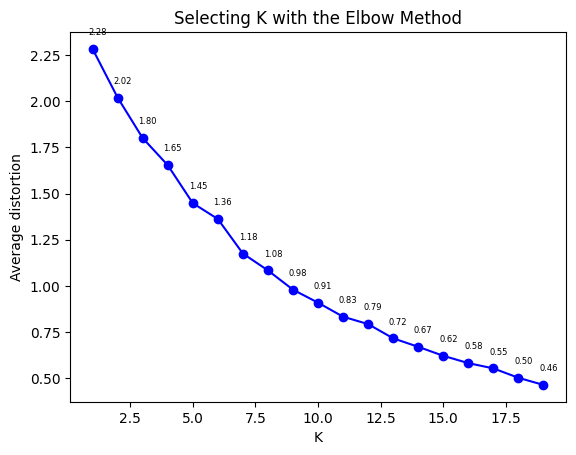

In [32]:
clusters = range(1, 20) # K range from 1 to 20
meanDistortions = []
inertias = []

for k in clusters: # Apply K-means for a range of values of K
    model = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    model.fit(arr_data_pd_scaled)
    prediction = model.predict(arr_data_pd_scaled)
    distortion = (
        sum(
            np.min(cdist(arr_data_pd_scaled, model.cluster_centers_, "euclidean"), axis=1)
        )
        / arr_data_pd_scaled.shape[0]
    )
    inertias.append(model.inertia_)

    meanDistortions.append(distortion)

# Plot distortion graph
plt.plot(clusters, meanDistortions, "bo-")
plt.xlabel("K")
plt.ylabel("Average distortion")
plt.title("Selecting K with the Elbow Method")
for x,y in zip(clusters, meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 size=6,
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Not much of an elbow ... looking for something more like this ...

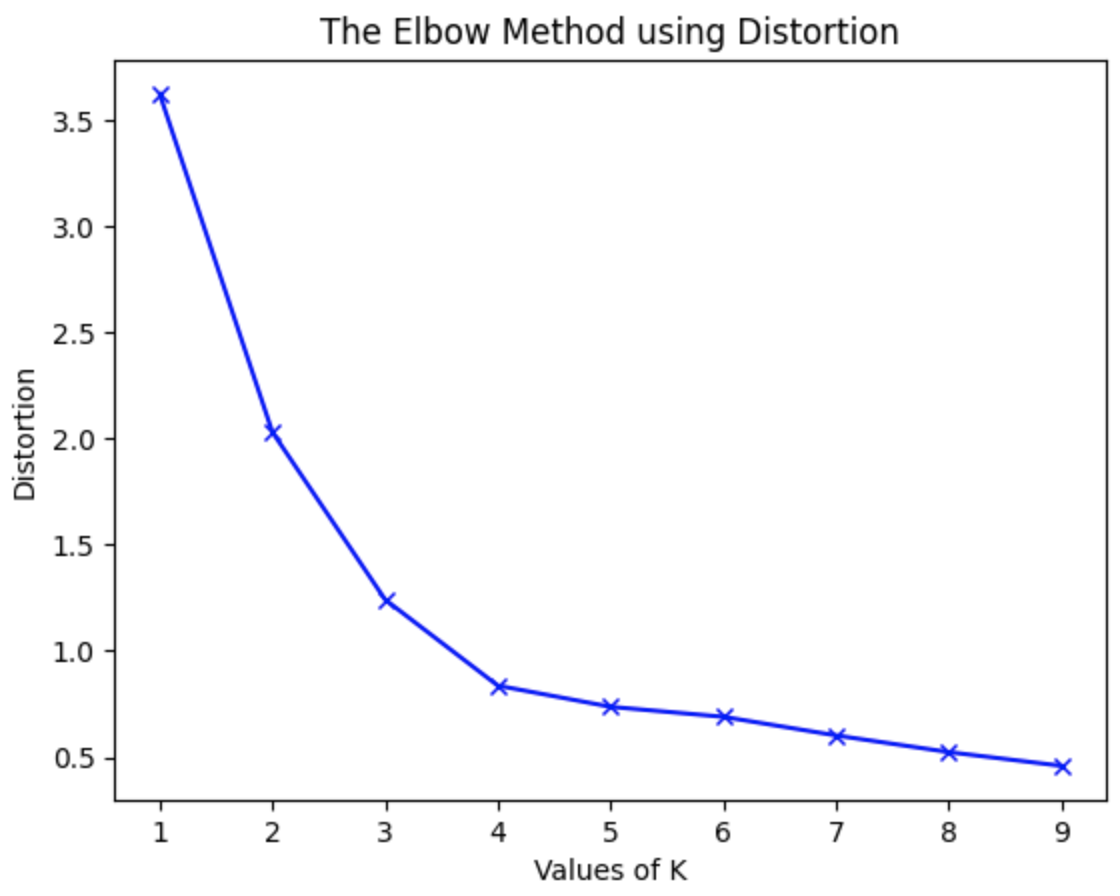

Lets try alternative inertia method ...

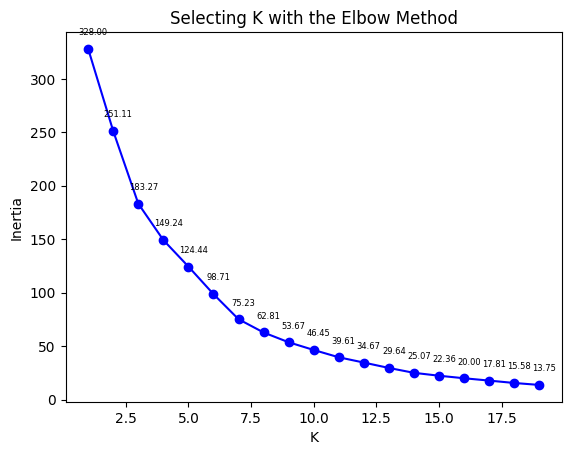

In [33]:
# Plot inertia graph
plt.plot(clusters, inertias, "bo-")
plt.xlabel("K")
plt.ylabel("Inertia")
plt.title("Selecting K with the Elbow Method")
for x,y in zip(clusters, inertias):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 size=6,
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Still no real sign of an elbow ... lookimg for something more like this ...

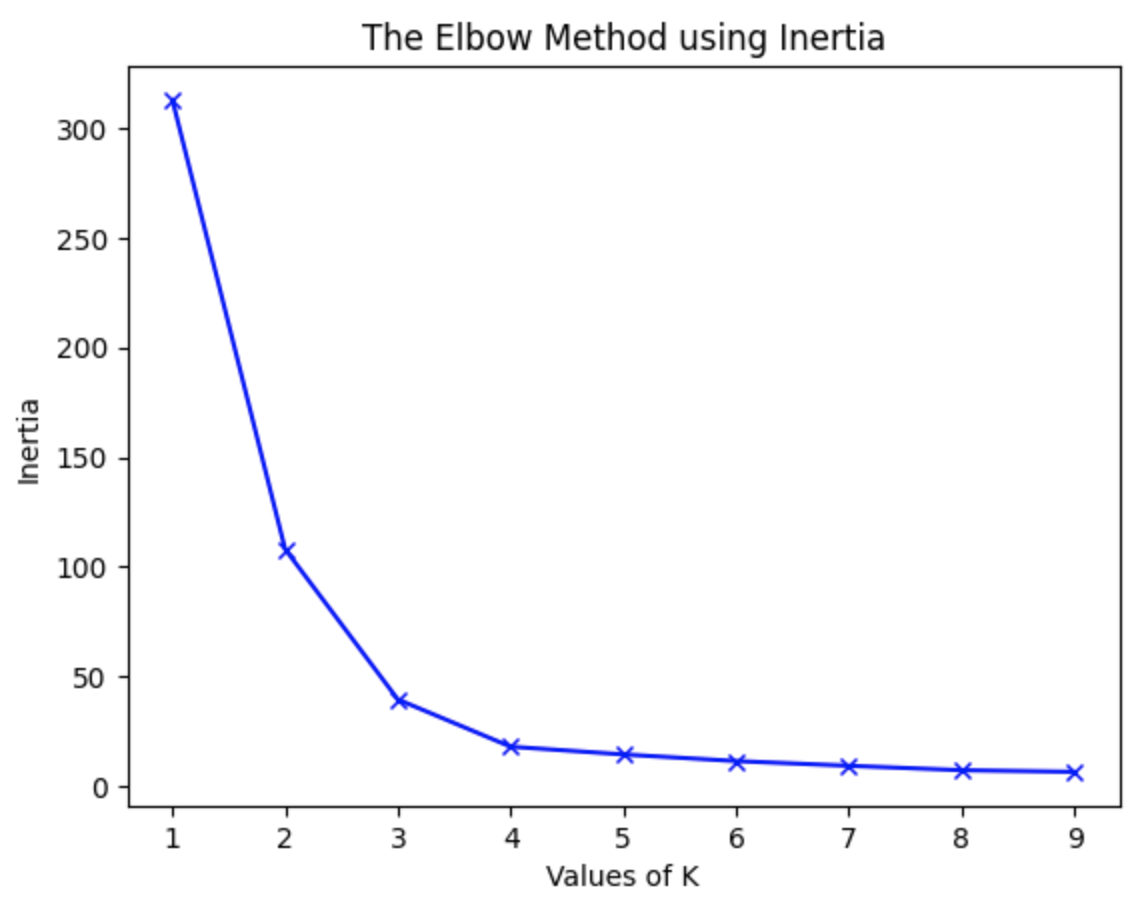

Results from elbow analysis are inconclusive

Next try Davie-Bouldin index ... 

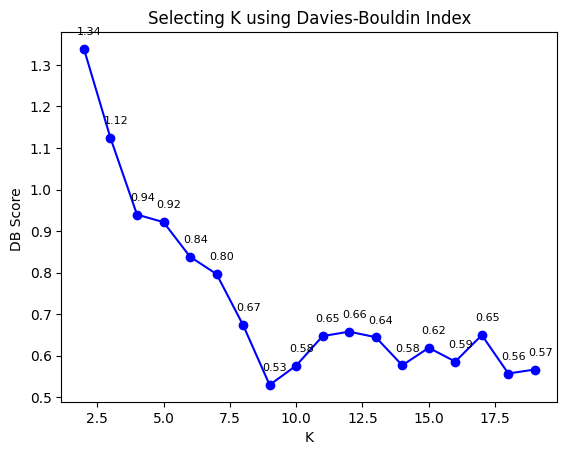

In [34]:
db_score = []
cluster_list = list(range(2, 20))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    centers = clusterer.cluster_centers_
    score = davies_bouldin_score(arr_data_pd_scaled, preds)
    db_score.append(score)

plt.plot(cluster_list, db_score, "bo-")
plt.xlabel("K")
plt.ylabel("DB Score ")
plt.title("Selecting K using Davies-Bouldin Index")
for x,y in zip(cluster_list, db_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 size=8,
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

A lower DBI indicates better clustering ... this would seem to be about K=9

See https://www.linkedin.com/advice/0/what-some-challenges-limitations-cluster-analysis for discussion ... apparently DBI can be sensitive to noise and outliers ... given the nature of this dataset (see later PCA plot) this may explain poor DBI ...

Next try Calinski-Harabasz ...

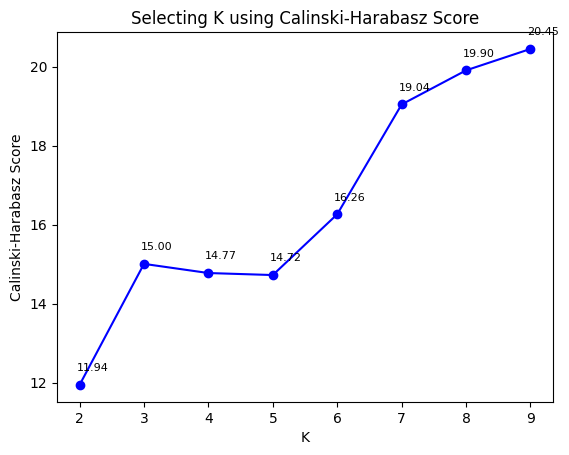

In [35]:
ch_score = []
cluster_list = list(range(2, 10))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    centers = clusterer.cluster_centers_
    score = calinski_harabasz_score(arr_data_pd_scaled, preds)
    ch_score.append(score)

plt.plot(cluster_list, ch_score, "bo-")
plt.xlabel("K")
plt.ylabel("Calinski-Harabasz Score")
plt.title("Selecting K using Calinski-Harabasz Score")
for x,y in zip(cluster_list, ch_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 size=8,
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

A higher value is preferable, but can also look for elbow in the plot ... seems to be a bit of a plateau between 3 and 5 clusters

Next try basic Silhouette Score

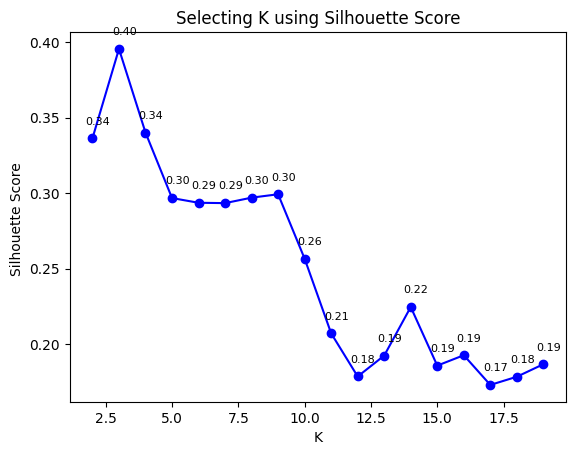

In [36]:
sil_score = []
cluster_list = list(range(2, 20))
for k in cluster_list:
    clusterer = KMeans(n_clusters=k, n_init=25, max_iter = 600, random_state=0)
    preds = clusterer.fit_predict(arr_data_pd_scaled)
    centers = clusterer.cluster_centers_
    score = silhouette_score(arr_data_pd_scaled, preds)
    sil_score.append(score)

plt.plot(cluster_list, sil_score, "bo-")
plt.xlabel("K")
plt.ylabel("Silhouette Score ")
plt.title("Selecting K using Silhouette Score")
for x,y in zip(cluster_list, sil_score):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x + 0.2,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 size=8,
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

Looks like 3 clusters, but not a good score ... preference is 0.6 or above

Hoever, does seem to be consistent with PCA (see later)

I have some concerns about aoplying PCA to time-series data given the complex temporal interaction between metabolites, but it might be worth a try ...

Lets start with K=3 ...

In [88]:
kmeans = KMeans(n_clusters=3, n_init=25, max_iter = 600, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)

In [89]:
principalDf.head(5)

,principal component 1,principal component 2,principal component 3,principal component 4,cluster
0,-1.955949,2.637835,-0.986052,-0.743320,0
1,-4.709437,6.339025,-0.497815,-0.866991,0
2,1.453560,-0.523067,-0.403289,-1.578492,3
3,1.885759,2.362095,4.947509,-0.922408,3
4,-1.502490,-1.355206,-1.647930,-0.488372,1


[36.8 27.5 21.   5.8]


/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_77112/417332841.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_77112/417332841.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


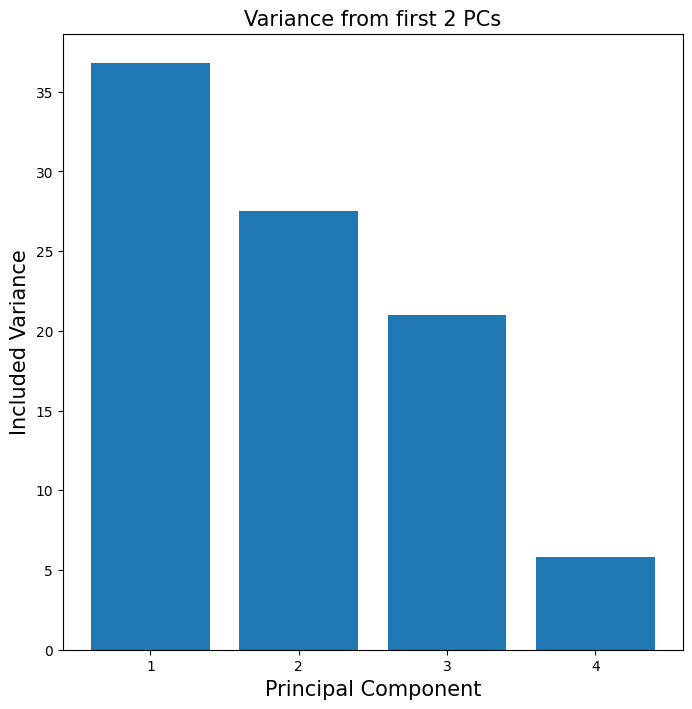

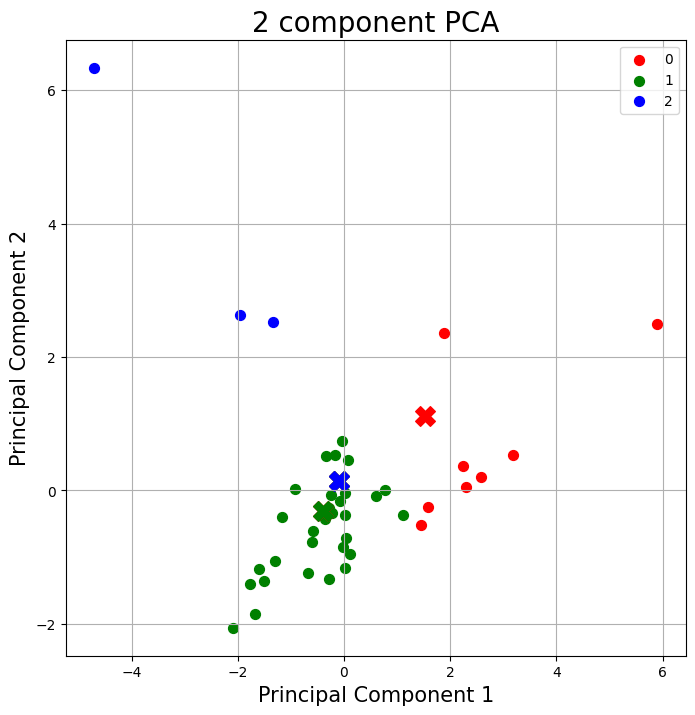

In [92]:
pca = PCA(n_components=4) # Do first 4 principle components
principalComponents = pca.fit_transform(arr_data_pd_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
principalDf['cluster'] = kmeans.labels_
principalDf.head(5)
centroids = kmeans.cluster_centers_
labels = principalDf.cluster.unique()
fig = plt.figure(figsize=(8,8))
g = fig.add_subplot(1,1,1)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(var)
lbls = [str(x) for x in range(1,len(var)+1)]
g.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
g.set_xlabel('Principal Component', fontsize = 15)
g.set_ylabel('Included Variance', fontsize = 15)
g.set_title('Variance from first 2 PCs', fontsize = 15)
fig.show()
fig = plt.figure(figsize = (8,8))
g = fig.add_subplot(1,1,1) 
g.set_xlabel('Principal Component 1', fontsize = 15)
g.set_ylabel('Principal Component 2', fontsize = 15)
g.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2]
colors = ['red', 'green', 'blue']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['cluster'] == target
    g.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
for i in range(0, len(labels)):
    g.scatter(centroids[i:,0] , centroids[i:,1] , c = colors[i], s = 200, marker="X")
g.legend(targets)
g.grid()
fig.show()

Green and red centroids not too bad, but blue particularly bad ... green and blue centroids very close ... blue could well be considered noise/outliers

Try again with K=4 to see if it makes any difference ...

In [93]:
kmeans = KMeans(n_clusters=4, n_init=25, max_iter = 600, random_state=0)
optimal_model = kmeans.fit(arr_data_pd_scaled)

In [94]:
principalDf.head(5)

,principal component 1,principal component 2,principal component 3,principal component 4,cluster
0,-1.955949,2.637835,-0.986052,-0.743320,2
1,-4.709437,6.339025,-0.497815,-0.866991,2
2,1.453560,-0.523067,-0.403289,-1.578492,0
3,1.885759,2.362095,4.947509,-0.922408,0
4,-1.502490,-1.355206,-1.647930,-0.488372,1


[36.8 27.5 21.   5.8]


/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_77112/3342269273.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/wc/qp7vtgqs2h78q8fxyh4vjjb80000gn/T/ipykernel_77112/3342269273.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


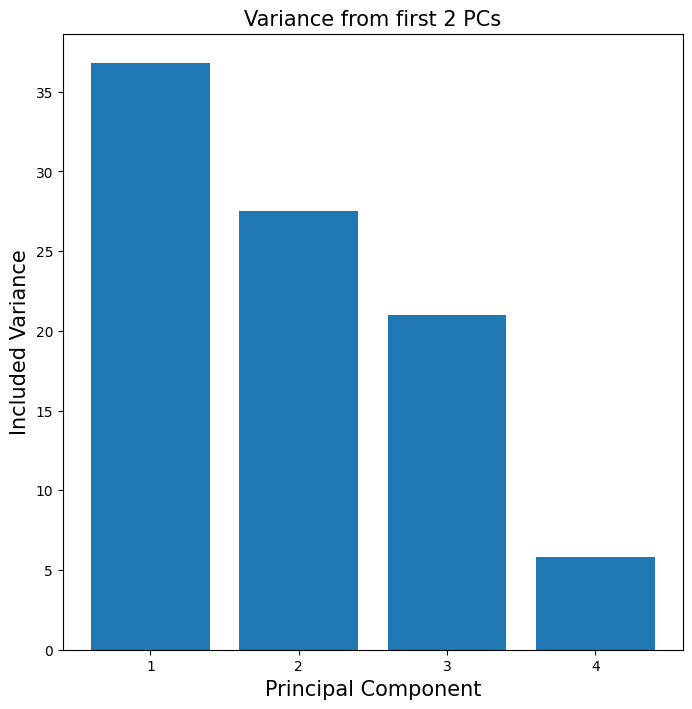

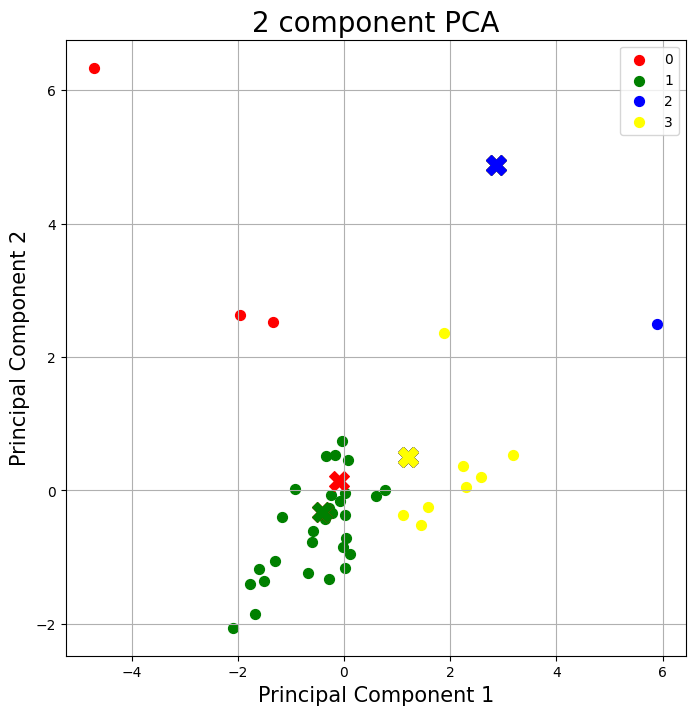

In [95]:
pca = PCA(n_components=4) # Do first 4 principle components
principalComponents = pca.fit_transform(arr_data_pd_scaled)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])
principalDf['cluster'] = kmeans.labels_
principalDf.head(5)
centroids = kmeans.cluster_centers_
labels = principalDf.cluster.unique()
fig = plt.figure(figsize=(8,8))
g = fig.add_subplot(1,1,1)
var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
print(var)
lbls = [str(x) for x in range(1,len(var)+1)]
g.bar(x=range(1,len(var)+1), height = var, tick_label = lbls)
g.set_xlabel('Principal Component', fontsize = 15)
g.set_ylabel('Included Variance', fontsize = 15)
g.set_title('Variance from first 2 PCs', fontsize = 15)
fig.show()
fig = plt.figure(figsize = (8,8))
g = fig.add_subplot(1,1,1) 
g.set_xlabel('Principal Component 1', fontsize = 15)
g.set_ylabel('Principal Component 2', fontsize = 15)
g.set_title('2 component PCA', fontsize = 20)
targets = [0, 1, 2, 3]
colors = ['red', 'green', 'blue', 'yellow',]
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['cluster'] == target
    g.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
for i in range(0, len(labels)):
    g.scatter(centroids[i:,0] , centroids[i:,1] , c = colors[i], s = 200, marker="X")
g.legend(targets)
g.grid()
fig.show()

Interesting no difference in variance coverage of first 3 principal components for K=3 vs K=4 (clusters different, but data the same)

Green and yellow centroids not too bad, but blue and red look like outliers/noise

It is possible to do a nore detailed silhouette analysis ... look at scores with clusters, etc and with better visualisations (lloks like it is from yellowbrick package but this won't install properly ... MacOS > 10.6)

More information https://www.baeldung.com/cs/silhouette-values-clustering#:~:text=A%20silhouette%20plot%20is%20a%20graphical%20tool%20we%20use%20to,and%20separation%20of%20the%20clusters.

Reference in above suggests we should target a value > 0.7 (https://onlinelibrary.wiley.com/doi/book/10.1002/9780470316801)

Description from https://towardsdatascience.com/silhouette-method-better-than-elbow-method-to-find-optimal-clusters-378d62ff6891

Code from https://gist.githubusercontent.com/satkr7/2a45e3d4af279458b48eba32add0d17e/raw/e9d6796a57098bd29ded167238b6c1f7e9463ce1/silhouette_method.py

In [112]:
#print(arr_data_pd_scaled)
#print(type(arr_data_pd_scaled))

/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_in

For n_clusters = 2 The average silhouette_score is : 0.3362822532295169
For n_clusters = 3 The average silhouette_score is : 0.36926102027773555
For n_clusters = 4 The average silhouette_score is : 0.3400991236511174
For n_clusters = 5 The average silhouette_score is : 0.22971252467611306


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.29361669329089296
For n_clusters = 7 The average silhouette_score is : 0.29338857225590004
For n_clusters = 8 The average silhouette_score is : 0.29700929660578


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.29924584273611277
For n_clusters = 10 The average silhouette_score is : 0.30561859872727587
For n_clusters = 11 The average silhouette_score is : 0.24246754747332397


/Users/johnpearce/opt/miniconda3/envs/SOM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 12 The average silhouette_score is : 0.18769777212477284


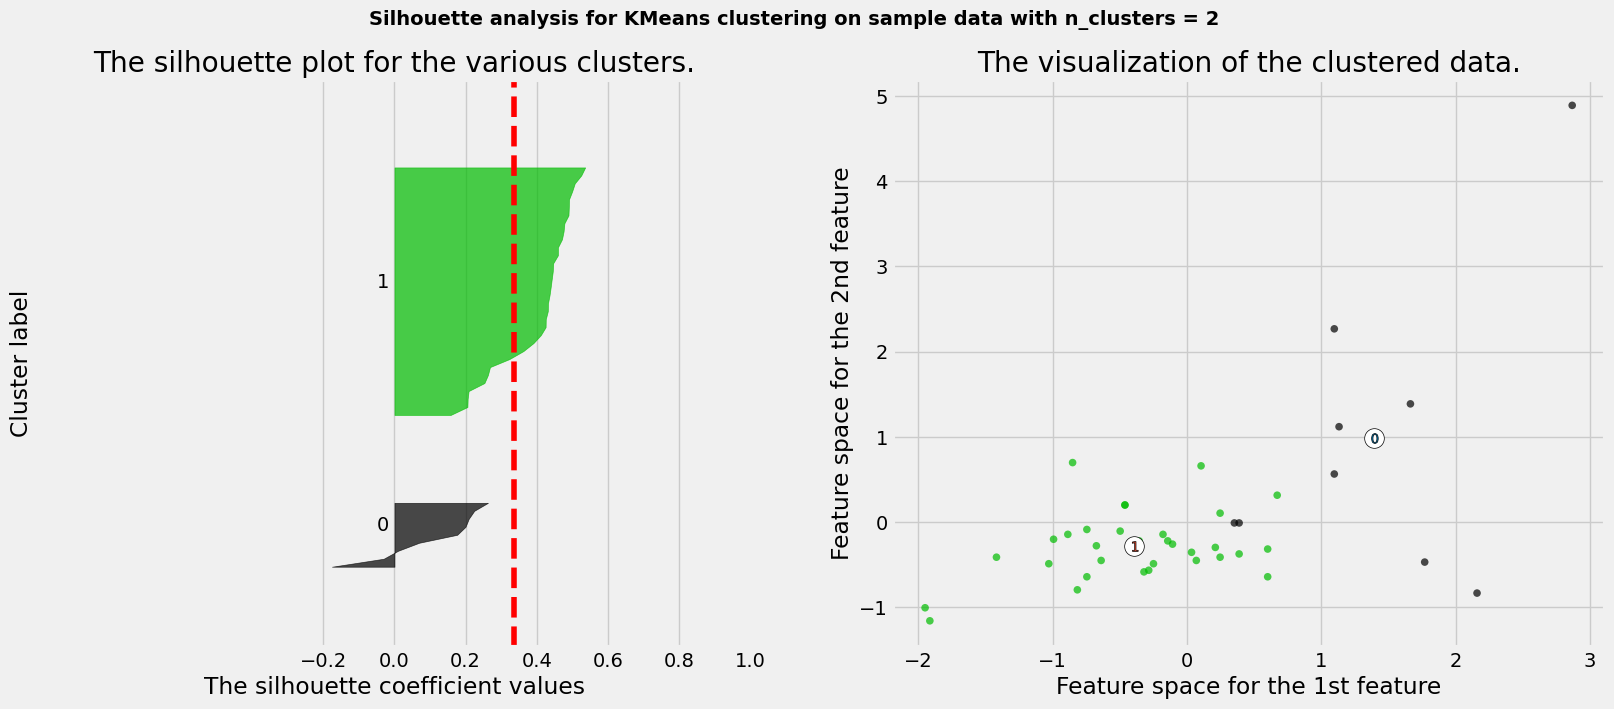

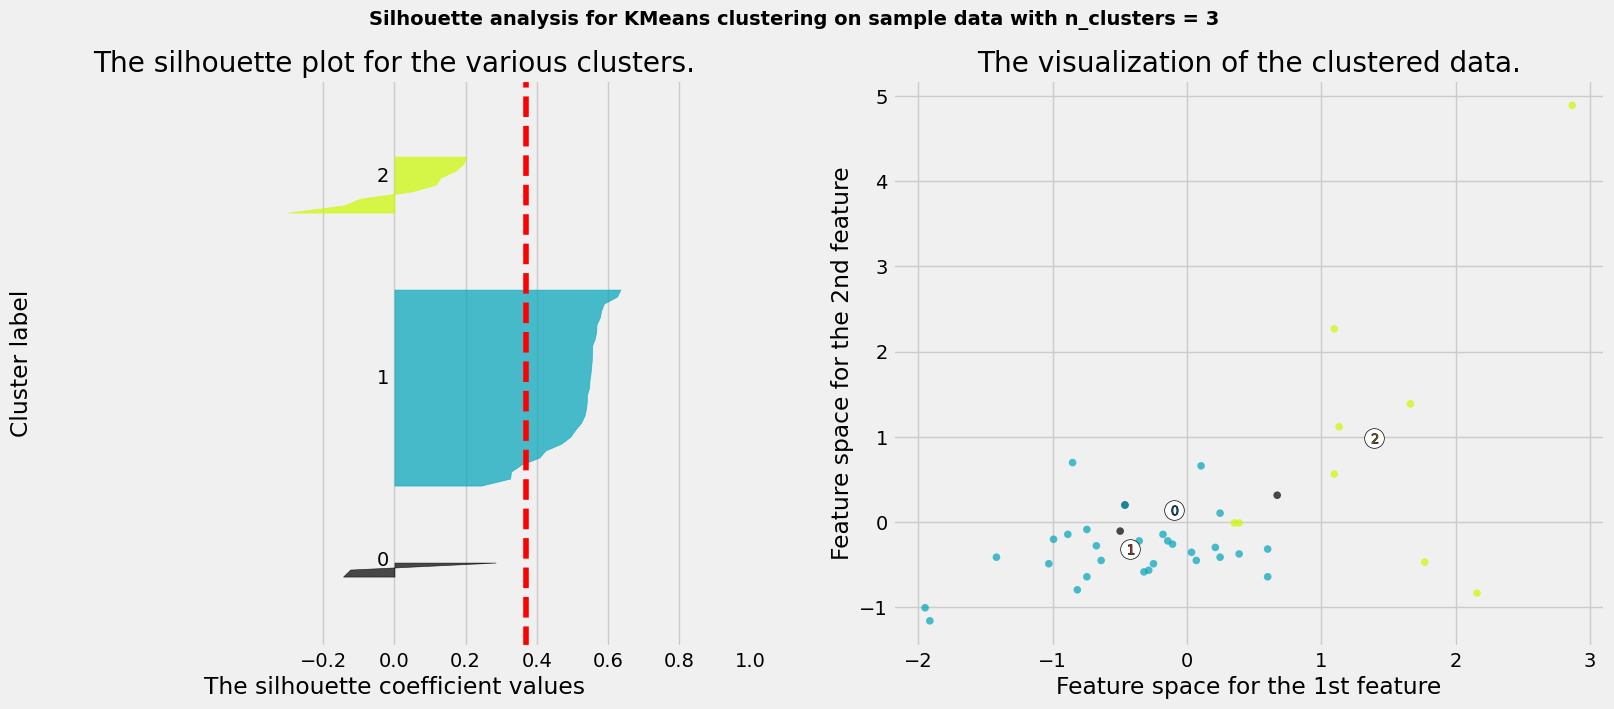

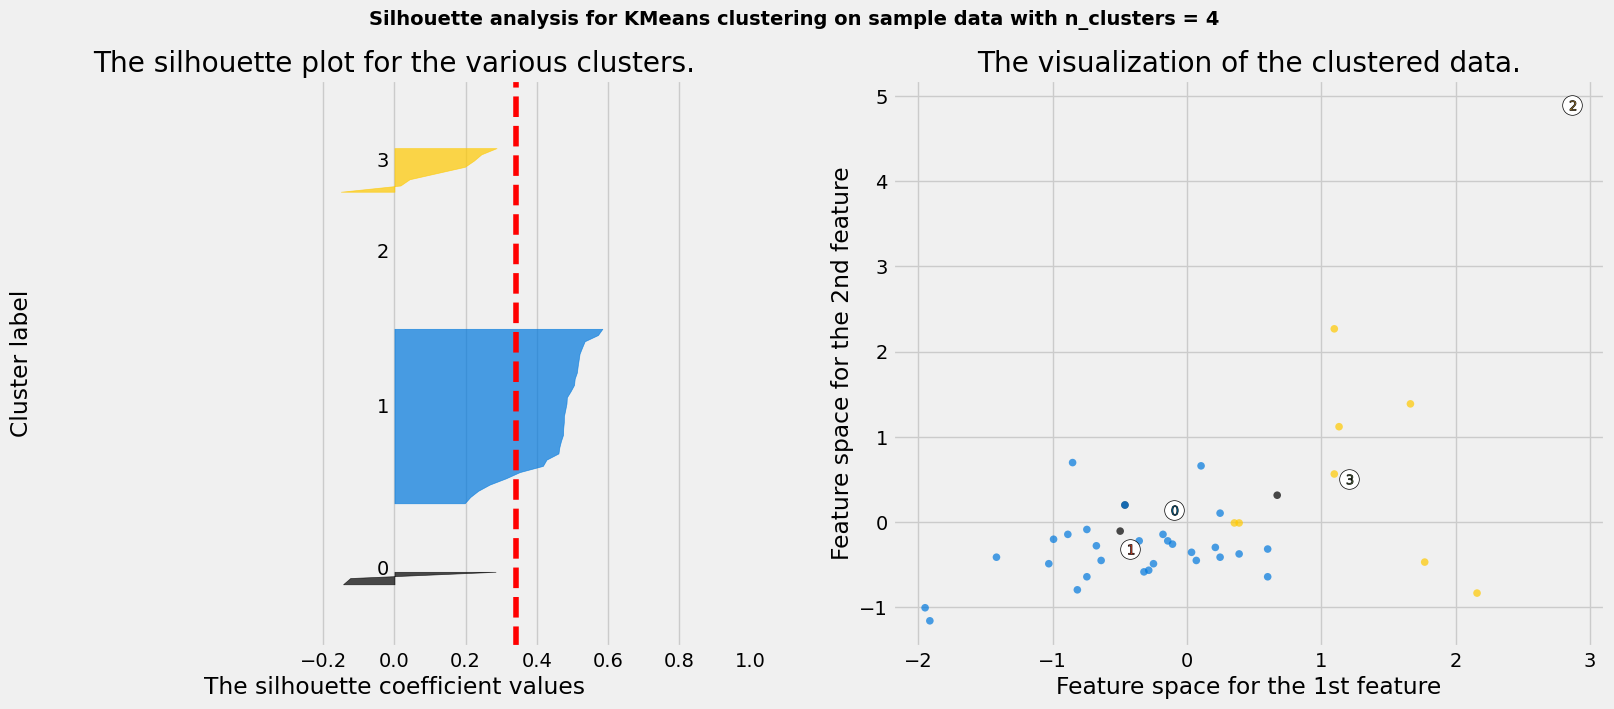

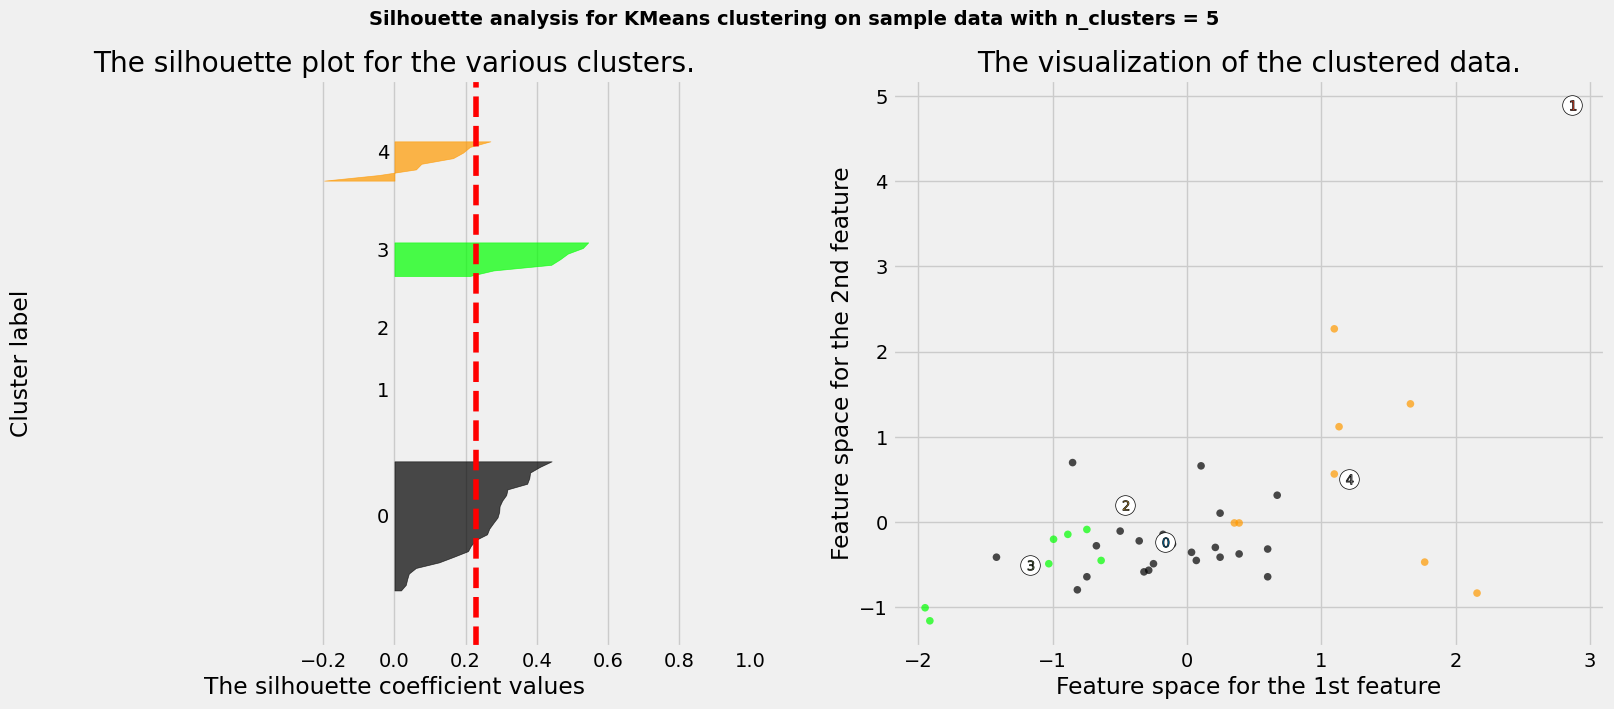

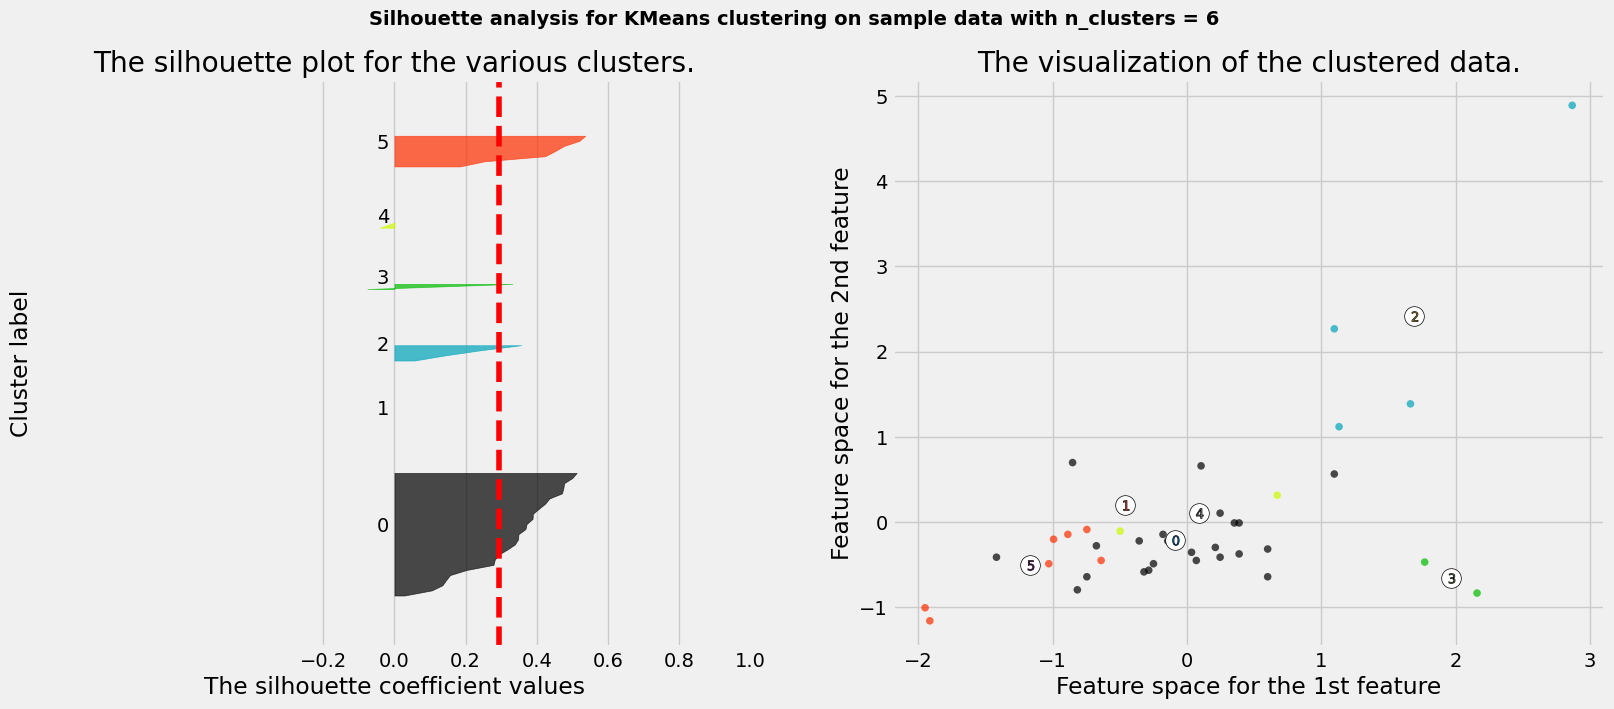

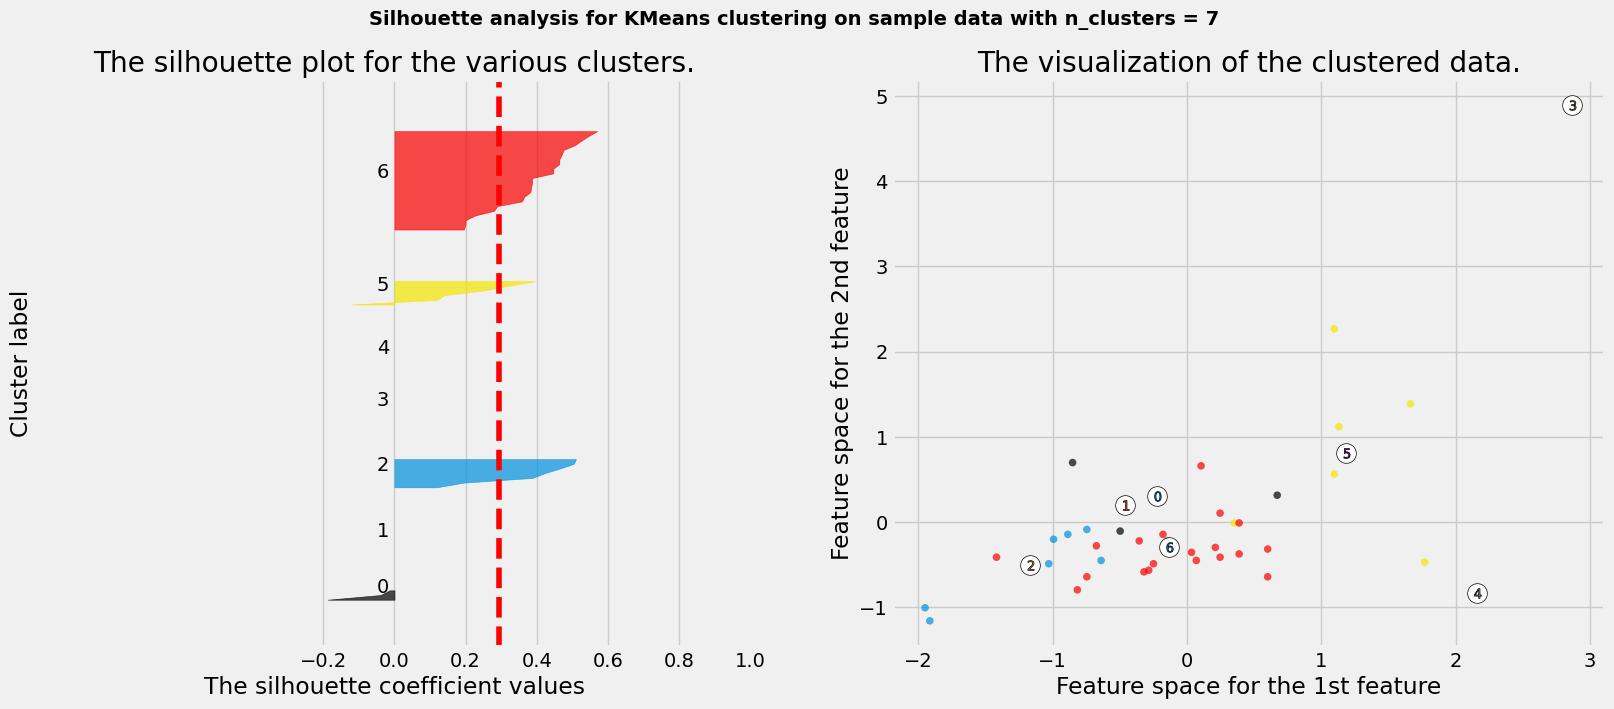

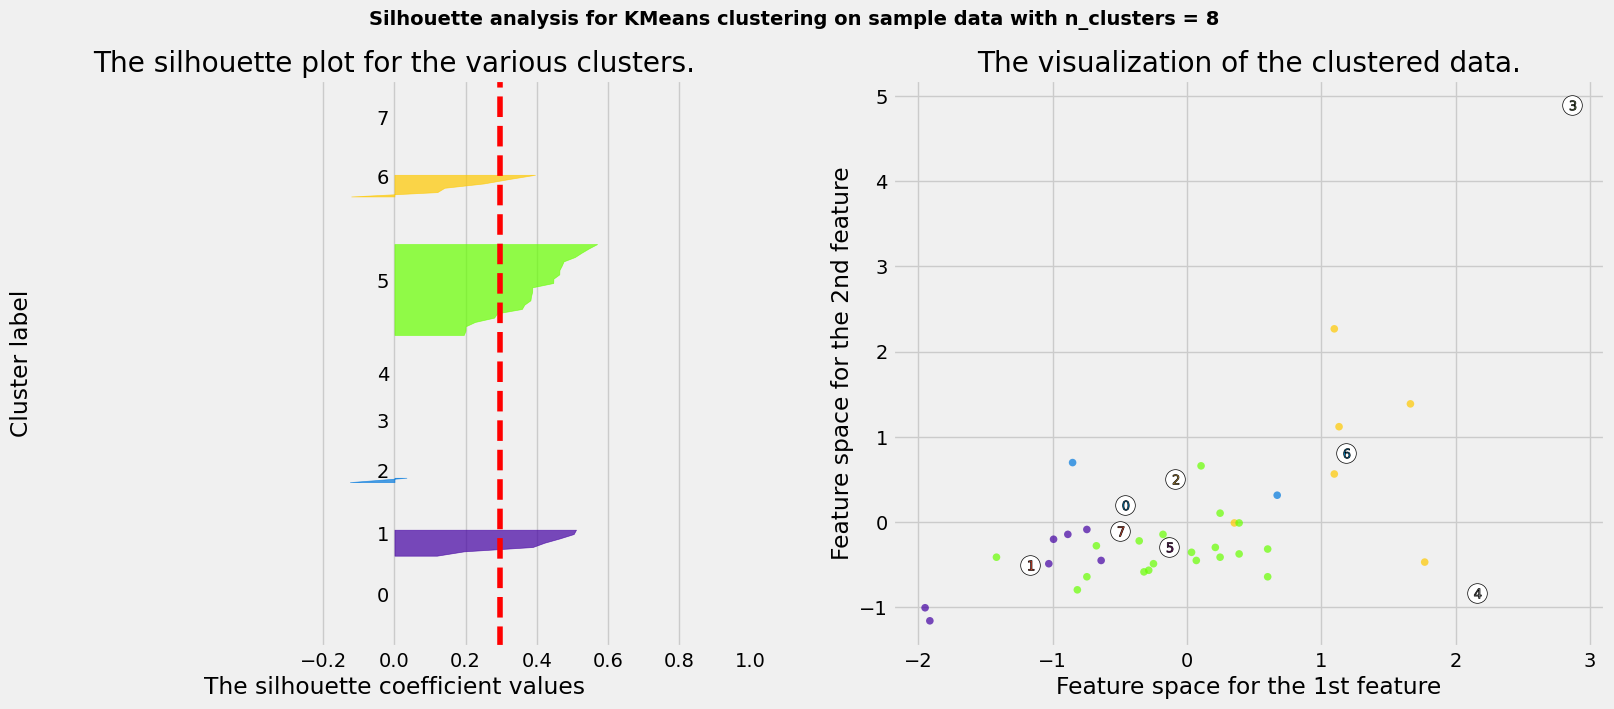

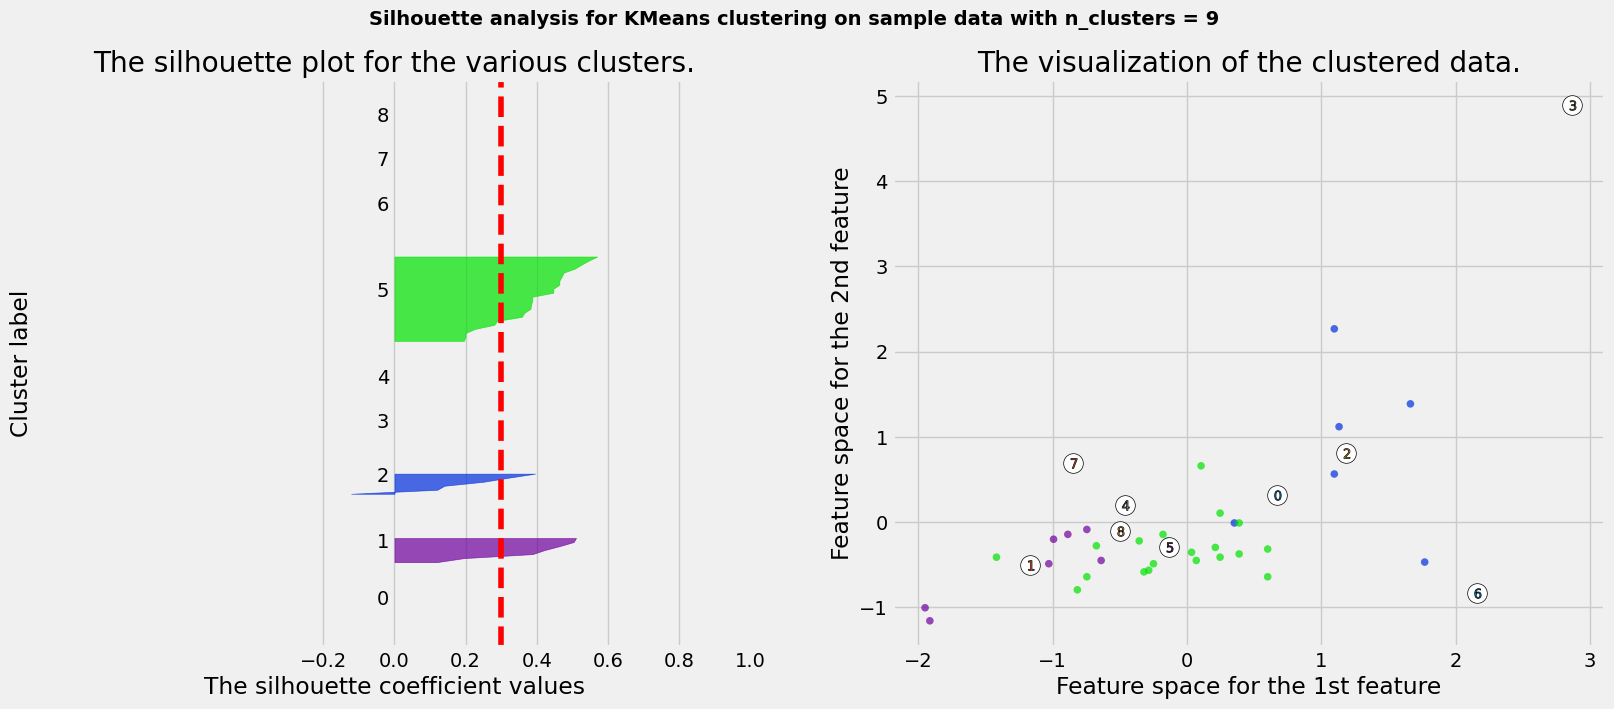

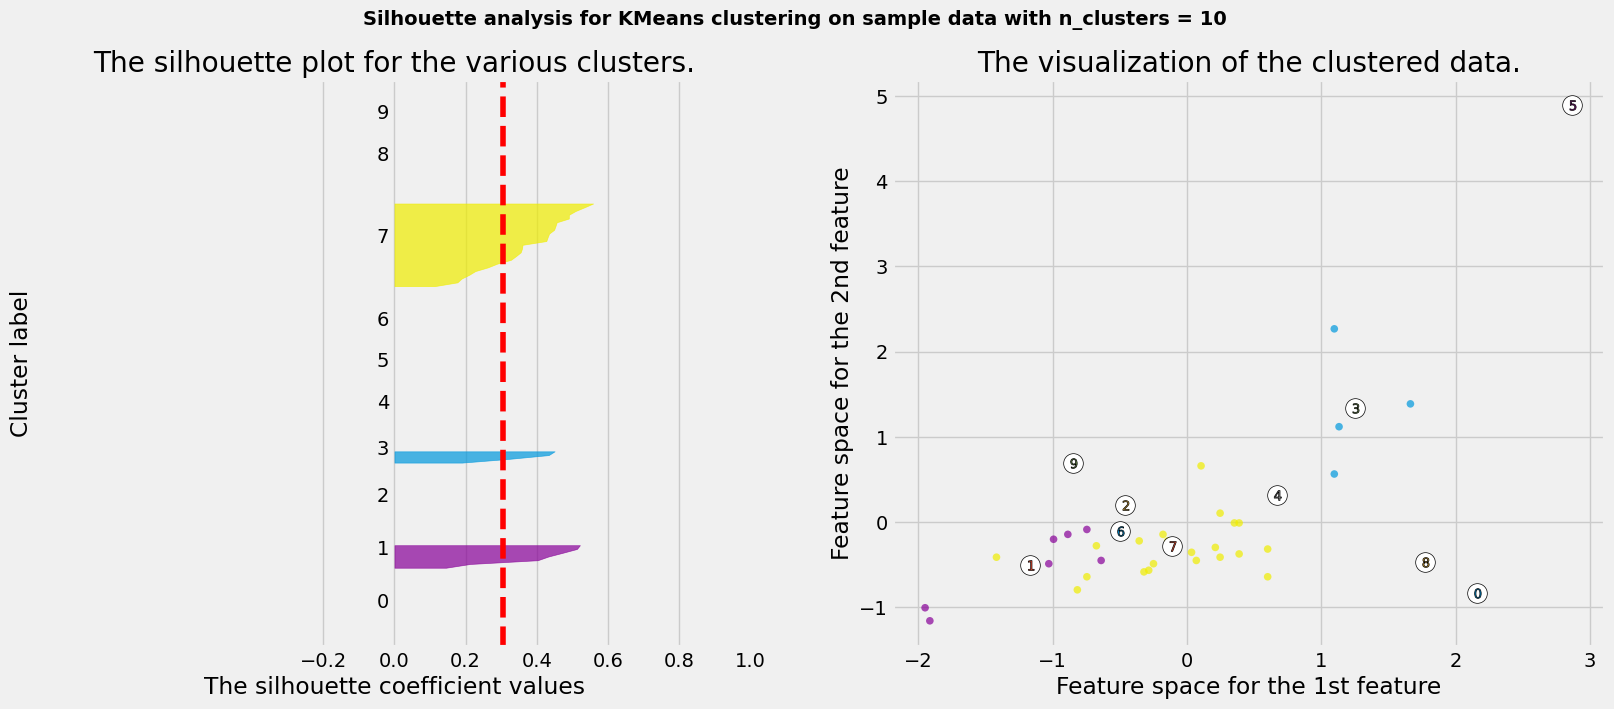

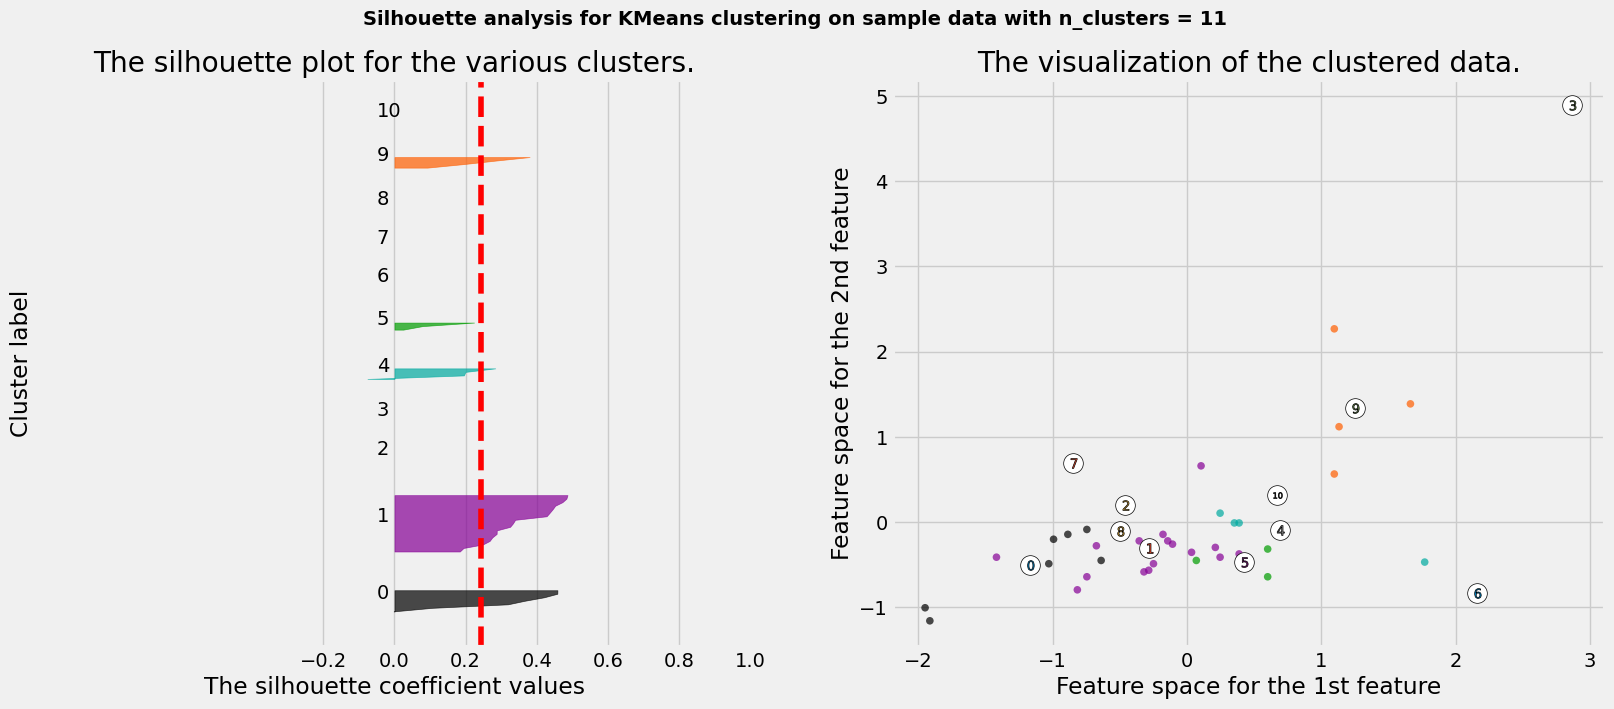

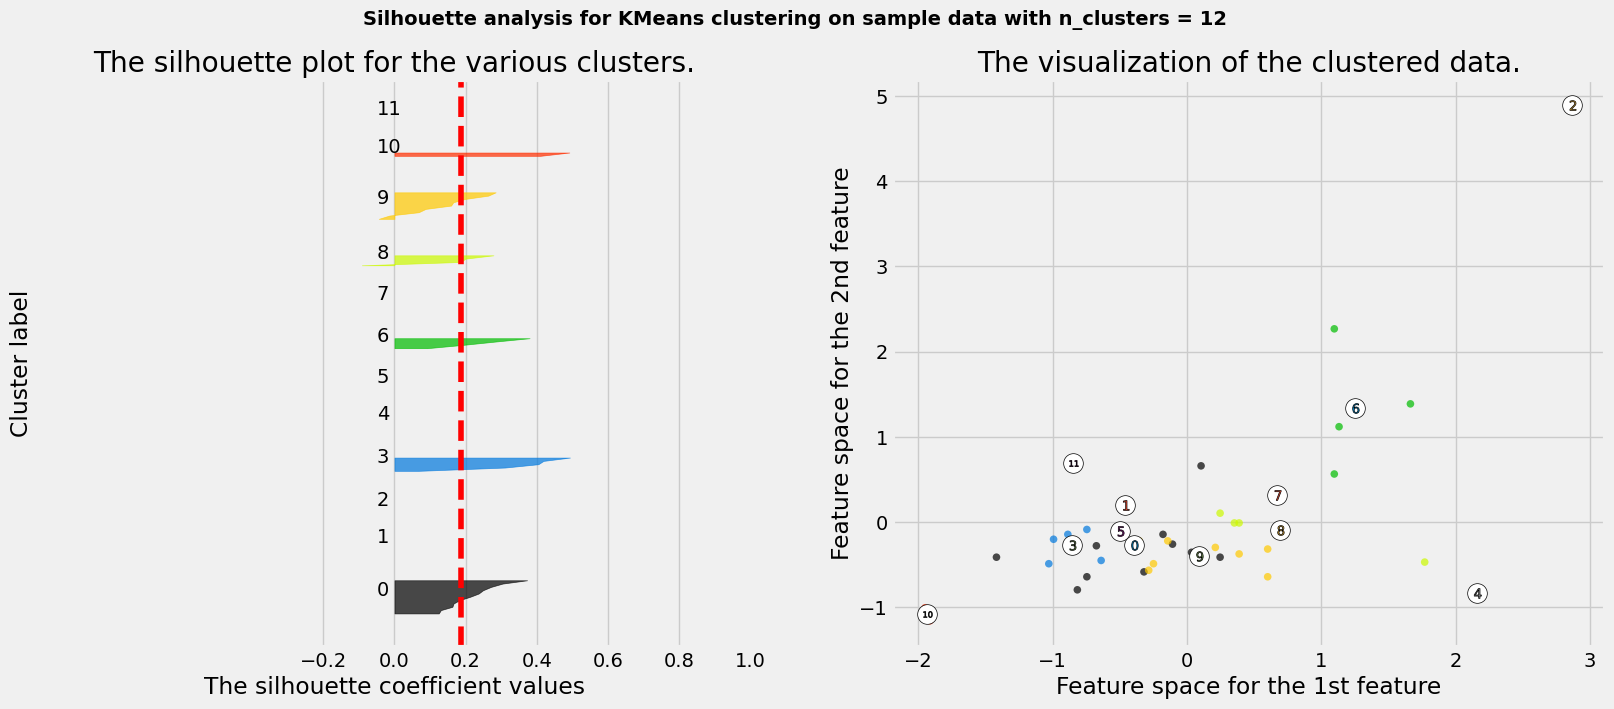

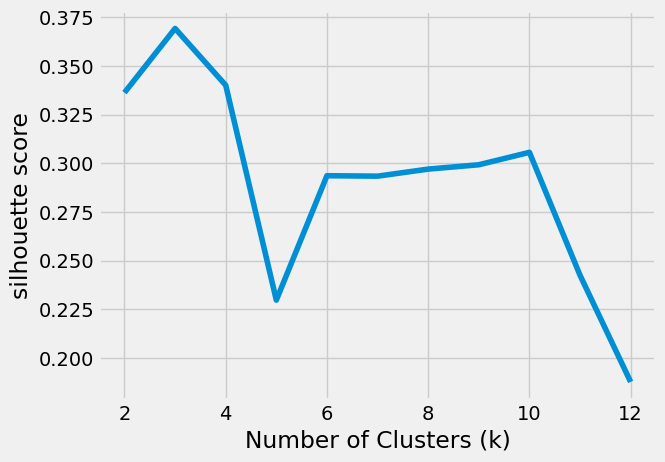

In [111]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
silhouette_avg_n_clusters = []

scaler = StandardScaler()
sil_data = arr_data_pd.to_numpy()
sil_data_scaled = scaler.fit_transform(sil_data)


#print(sil_data_scaled)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(sil_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(sil_data_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(sil_data_scaled, cluster_labels, metric='euclidean')
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(sil_data_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(sil_data_scaled[:, 0], sil_data_scaled[:, 1], marker='o', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

Graph just to double check against previous graph - use previous graph as format is better

Ideally want something like this ... average score > 0.7, all clusters cross average and no negative data (wrong classified)

Note we have 'negative' data which isn't a good sign ... basically data in the wrong cluster

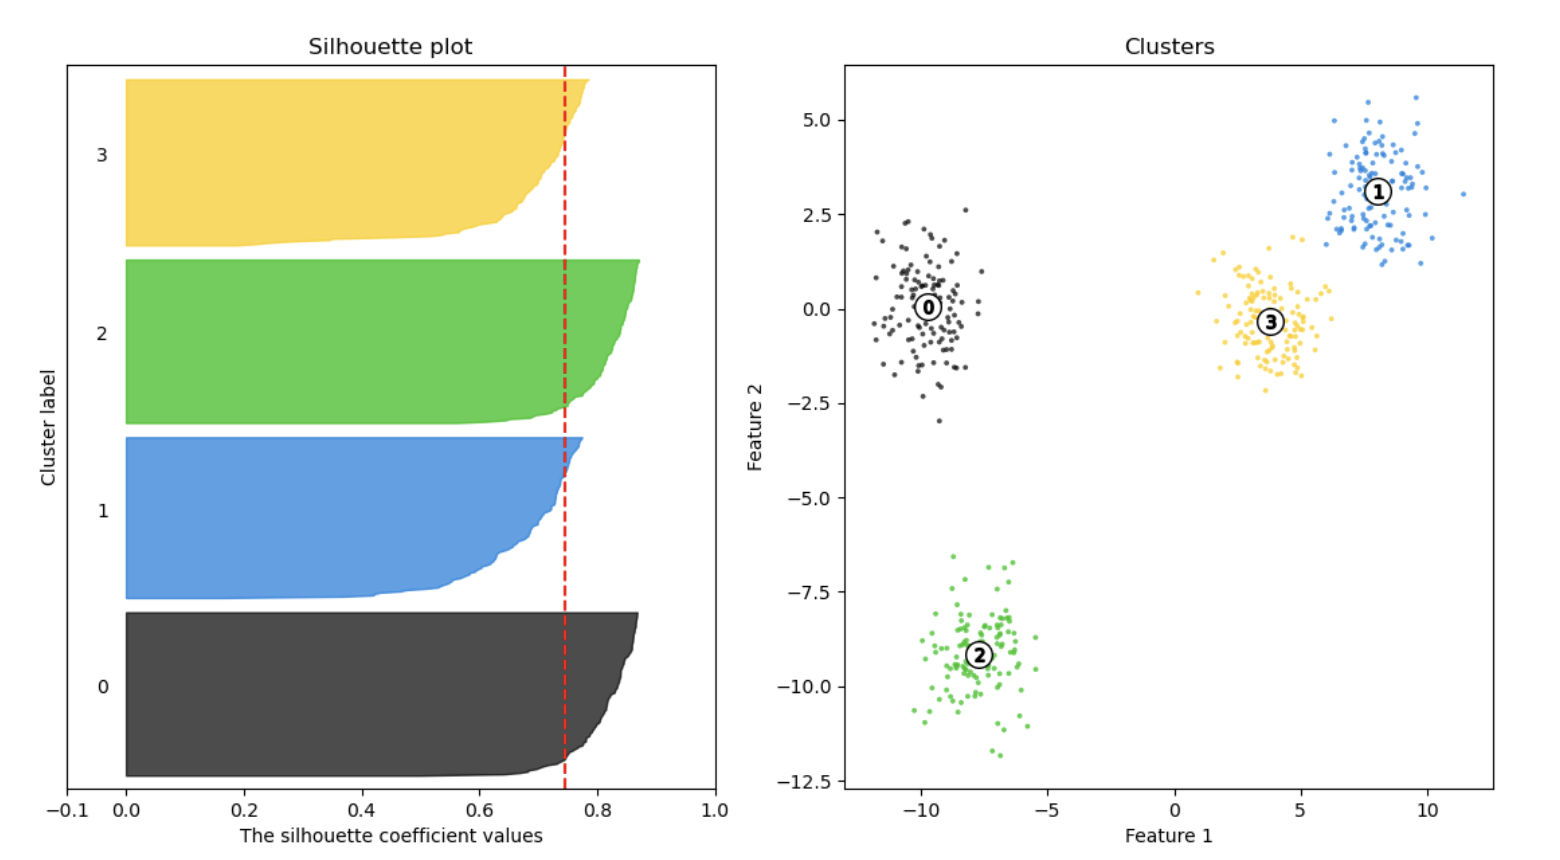

Add cluster numbers

In [357]:
arr_data_pd['cluster'] = kmeans.labels_
arr_data_pd['metabolite'] = metabolites
arr_data_pd.head(5)

,2,3,4,5,6,7,8,9,cluster,metabolite
0,1.19,1.32,0.86,0.68,0.54,1.84,3.23,3.63,0,PYRUVATE
1,0.87,1.26,0.98,0.67,0.53,4.94,3.67,12.75,0,LACTATE
2,1.31,1.45,1.18,1.22,0.52,0.59,0.31,0.26,2,ETHANOL-AMINE
3,1.61,0.72,0.68,1.91,1.42,3.30,0.90,1.40,2,GLYCEROL
4,0.75,1.08,0.80,0.55,0.39,0.21,0.87,1.62,1,SUC


Print out cluster contents

In [286]:
for n in range(0, 3):
    print("Cluster ", n)
    for i in range(0, arr_data_pd.shape[0]):
        if (arr_data_pd.loc[i, 'cluster'] == n):
            print(arr_data_pd.loc[i,'metabolite'])

Cluster  0
PYRUVATE
LACTATE
SUCROSE
Cluster  1
SUC
GLYCERATE
FUM
CADAVERINE
MAL
4-AMINO-BUTYRATE
CYS
2-KETOGLUTARATE
PUTRESCINE
SHIKIMATE
FRU
GLUCOSE
GLUCONATE
CPD0-1083
URATE
TREHALOSE
L-ASPARTATE
ASN
SER
GLY
L-ALPHA-ALANINE
GLT
GLN
THR
PRO
VAL
ILE
FORMATE
FOLATES
Cluster  2
ETHANOL-AMINE
GLYCEROL
CIS-ACONITATE
CIT
LYS
TYR
TRP
LEU
PHE
